##### Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/tree_detection
#%ls

/content/drive/MyDrive/tree_detection


In [ ]:
!pip install imagecodecs > /dev/null
!pip install rasterio > /dev/null
!pip install geopandas > /dev/null
!pip install geojson > /dev/null

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Imports and parameters

In [65]:
# standard library imports
import argparse
import glob 
import os
import sys
import tempfile

# other library imports
import cv2
import geopandas as gpd
import geojson 
import h5py as h5
import imageio
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
import rasterio
import rasterio.transform
from tqdm import tqdm

# deep learning library imports
#import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# local module imports
from scripts.VGG import *
from scripts.SFANet import *
from scripts.Inference import *
from scripts.evaluate import *
from scripts.datasets import TreeDataset
from scripts.test import test_model, plot_test_data
from scripts.train import train_model

In [67]:
# define paramters, paths etc.

# set to True if you want to do any of
training = False
testing = False

data_type = "RGB" # RGBN for 4 or 5 channels
channels = None # or 5 for RGBN

# training
batch_size = 4
num_epochs = 100
lr = 1e-4

# testing
min_distance = 1
threshold_abs = None
threshold_rel = 0.15

# train/test data
data_path = "datasets"

train_dataset = "tree_catastre_KL"  # change the dataset for example urban_tree_detection, tree_catastre_KL etc.
val_dataset = "tree_catastre_KL"
test_dataset = "tree_catastre_KL"

train_images_path = f"datasets/{train_dataset}/images"  # contains 256x256 .tif files
train_csv_path = f"datasets/{train_dataset}/csv" # contains respecitve .csv files
train_path = f"datasets/{train_dataset}/test.txt" # list of basename of csv / image files

val_images_path = f"datasets/{val_dataset}/images" 
val_csv_path = f"datasets/{val_dataset}/csv"
val_path = f"datasets/{val_dataset}/test.txt" 
 
test_images_path = f"datasets/{test_dataset}/images" 
test_csv_path = f"datasets/{test_dataset}/csv"
test_path = f"datasets/{test_dataset}/test.txt"
meta_path = f"datasets/{test_dataset}/meta.pkl" # transformation metadata

# model files
load_model = True # load pre-trained model
model_path = "models/best_model_RGB_deepf.pt"

# KL data
kl_data_path = "datasets/tree_catastre_KL_raw"
kl_out_path = "datasets/tree_catastre_KL_deepforest_out"
tile_size = 512
overlap = 32

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Datasets

In [68]:
# create datasets, dataloaders etc.
train_dataset = TreeDataset(data_file=train_path, image_dir=train_images_path, csv_dir=train_csv_path, train=True)
val_dataset = TreeDataset(data_file=val_path, image_dir=val_images_path, csv_dir=val_csv_path, train=False)
test_dataset = TreeDataset(data_file=test_path, image_dir=test_images_path, csv_dir=test_csv_path, train=False, meta_dir=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=32)

Dataset length:  1707
Dataset length:  1707
Dataset length:  1707


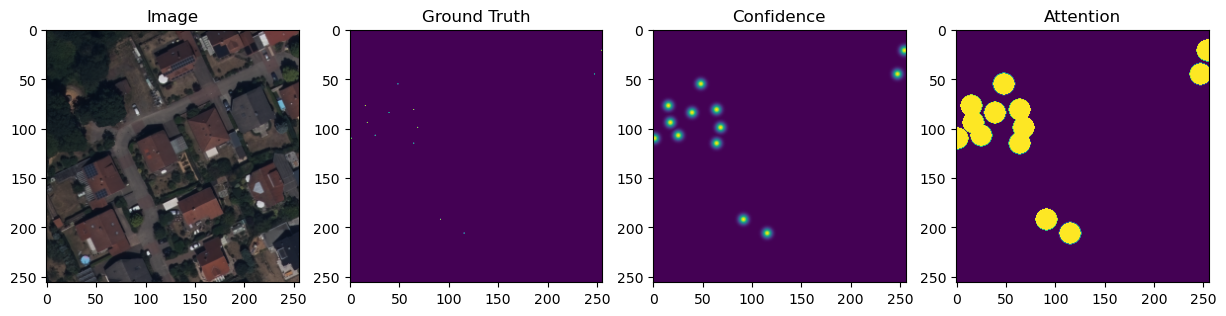

In [86]:
# visualize dataset

im, gt, conf, att, *rest = test_dataset[589]
if im != None: # if none -> csv or image file doesn't exist

    # undo preprocessing of image data
    denormalized_image = unprocess_image(im)  

    # create a figure with 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # plot the image
    axes[0].imshow(denormalized_image)
    axes[0].set_title('Image')

    # plot the ground truth map
    axes[1].imshow(gt)
    axes[1].set_title('Ground Truth')

    # plot the confidence map
    axes[2].imshow(conf,)
    axes[2].set_title('Confidence')

    # plot the attention map
    axes[3].imshow(att)
    axes[3].set_title('Attention')

    plt.show()

##### Building model

In [87]:
model = build_model(channels=None) # none -> original VGG with 3 channels
model.to(device)
if load_model:
    print("loading model")
    model.load_state_dict(torch.load(f"{model_path}", map_location=device))

loading model


##### Training

In [ ]:
# training the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, lr, model_path, device)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

Epoch: 40 Batch: 496/718 Loss: 0.0073500825092196465:  40%|████      | 40/100 [3:14:47<2:54:25, 174.42s/it]

##### Testing 

In [88]:
# testing
results = test_model(model, test_loader, device, min_distance=min_distance, threshold_abs=threshold_abs, threshold_rel=threshold_rel)
with open('results_deepf_015.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


------- results for: testing ---------
precision:  0.170850035589855
recall:  0.5254940369879587
fscore:  0.25786296877429565
rmse [px]:  6.862431949521496


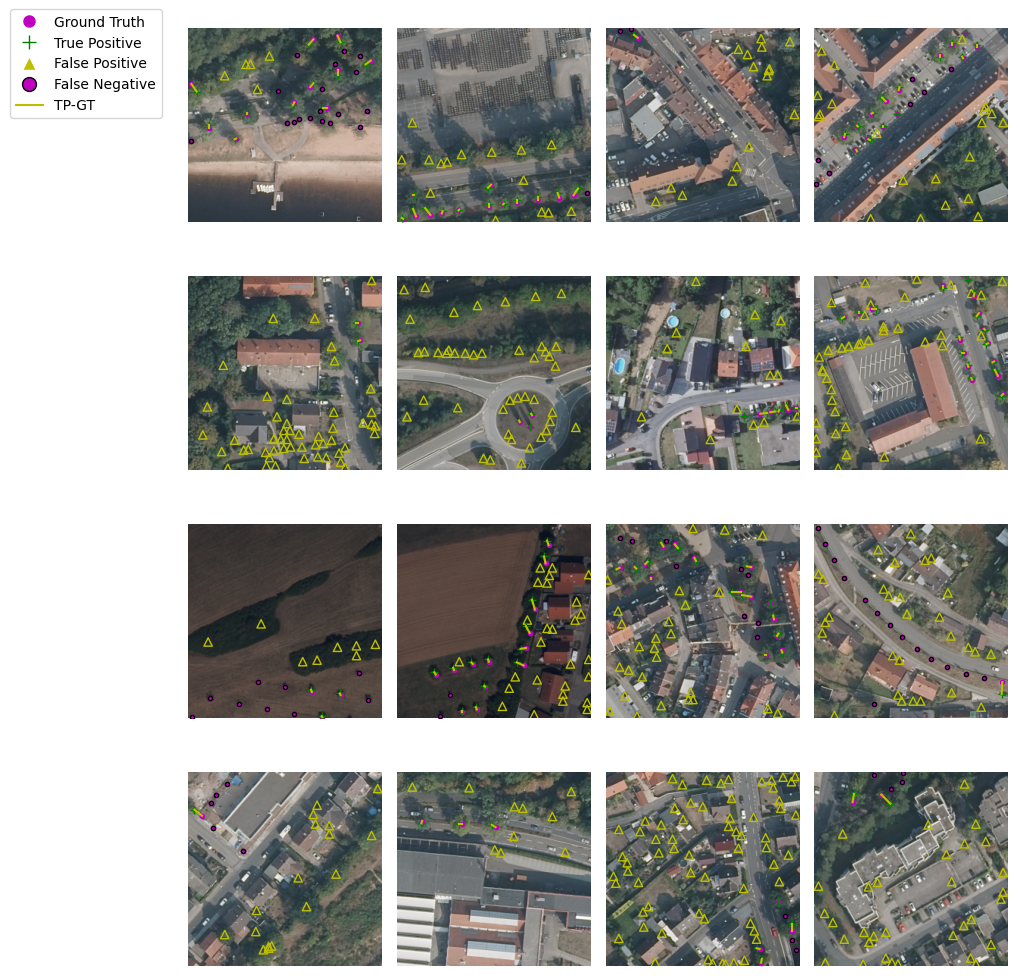

In [89]:
fig = plot_test_data(model, test_dataset, device, min_distance, threshold_abs, threshold_rel, n_samples=16, seed=1234)

##### Testing on tiles (old part)

In [ ]:
image_list = []
indices_list = []

if os.path.isdir(kl_data_path):
    os.makedirs(kl_out_path,exist_ok=True)
    paths = sorted(glob.glob(os.path.join(kl_data_path,'*.tif')) + glob.glob(os.path.join(kl_data_path,'*.tiff')))
    pbar = tqdm.tqdm(total=len(paths))
    for input_path in paths:
        output_path = os.path.join(kl_data_path,os.path.basename(input_path).split('.')[0]+'.json')
        if not os.path.exists(output_path):
            indices = run_tiled_inference(model,input_path,output_path,min_distance=min_distance,threshold_abs=threshold_abs,threshold_rel=threshold_rel,
                                device=device, tile_size=tile_size, overlap=overlap)
            indices_list.append(indices)
            image_list.append(input_path)
        #pbar.update(1)
df = pd.DataFrame({'images': image_list, 'indices': indices_list})
df.to_csv("tree_catastre_KL_output.csv", index=False)
df.head()        

In [ ]:
# saves each tile as .jpg including visualization of detected trees

for i in range(len(df)):
    im = cv2.imread(df['images'][i])
    coords = np.round(df['indices'][i]).astype(int)
    for coord in coords:
        cv2.drawMarker(im, tuple(coord[::-1]), (255, 0, 0), markerType=cv2.MARKER_SQUARE)
    im_name = os.path.basename(df['images'][i])
    im_name = os.path.splitext(im_name)[0] + ".jpg"
    cv2.imwrite(os.path.join(kl_out_path,im_name), im)

---

### other

